# Statistics and Probability (20592) - Final Project - Group 12 - Jan 11, 2024
### Lalic Pavle, Mancinelli Pierluigi, Martinelli Aurora, Nenkov Nikola Nikolaev, Paoli Susanna

<font color='blue'>Requirements: for the notebook to run smoothly, the dataset "SAheart.txt" must be in the same directory of this code.</font> \
<font color='red'>Warnings: for random walk Metropolis-Hastings, we performed 2,500,000 iterations, which might be computationally expensive for some machines. </font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import csv
import pandas as pd
from scipy.stats import norm
import scipy.stats
import os
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import statsmodels.api as smf

# Prepare the dataset

In [2]:
file_path = os.path.join(os.getcwd(),"SAheart.txt" )
with open(file_path, 'rt', newline = "\n") as f:
    reader = csv.reader(f, delimiter=' ')
    headers = next(reader, None)
    column = {}
    for h in headers:
        column[h] = []
    for row in reader:
        for h, v in zip(headers, row):
            column[h].append(v)

In [3]:
data = pd.DataFrame(column)

In [4]:
data.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12,5.73,23.11,Present,49,25.3,97.2,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.5,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.6,3.5,27.78,Present,60,25.99,57.34,49,1


In [5]:
data['famhist'] = data['famhist'].astype(str)
data['famhist_enc'] = data['famhist'].map({'Present': 1, 'Absent': 0})
data['intercept'] = 1
data['sbp'] = pd.to_numeric(data['sbp'])
data['tobacco'] = pd.to_numeric(data['tobacco'])
data['ldl'] = pd.to_numeric(data['ldl'])
data['adiposity'] = pd.to_numeric(data['adiposity'])
data['typea'] = pd.to_numeric(data['typea'])
data['obesity'] = pd.to_numeric(data['obesity'])
data['alcohol'] = pd.to_numeric(data['alcohol'])
data['age'] = pd.to_numeric(data['age'])
data['chd'] = pd.to_numeric(data['chd'])
data.dtypes

sbp              int64
tobacco        float64
ldl            float64
adiposity      float64
famhist         object
typea            int64
obesity        float64
alcohol        float64
age              int64
chd              int64
famhist_enc      int64
intercept        int64
dtype: object

In [6]:
data = data[['intercept', 'sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age', 'famhist_enc', 'chd']]
data.head()

,intercept,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,famhist_enc,chd
0,1,160,12.00,5.73,23.11,49,25.30,97.20,52,1,1
1,1,144,0.01,4.41,28.61,55,28.87,2.06,63,0,1
2,1,118,0.08,3.48,32.28,52,29.14,3.81,46,1,0
3,1,170,7.50,6.41,38.03,51,31.99,24.26,58,1,1
4,1,134,13.60,3.50,27.78,60,25.99,57.34,49,1,1


# Fisher-scoring method for Probit Regression

In [7]:
def probit(X,Y, epsilon):

    n,p = np.shape(X)
    overflow = 1e-10
    #Initial values of the algorithms
    b_0 = np.zeros((p,1))
    eta = np.dot(X, b_0) 
    
    print(n, p)
    
    # TO-DO
    
    # -----------------
    probs = norm.cdf(eta) # parameter of the bernoulli
    der = 1/(norm.pdf(eta)) # d_eta/d_mu
    W = np.diag(
        
        (1/(probs*(1-probs) + overflow)*(der**(-2) + overflow)
    
        ).reshape(n,))
    Z = eta + (Y - probs)*der
    
    # -----------------
    
    #boolean
    convergence = False
    while not convergence:
        
        #new estimate #add
        b = np.linalg.multi_dot([np.linalg.inv(np.linalg.multi_dot([X.T, W, X])), X.T,W, Z])
        eta = np.dot(X, b)
        
        # TO-DO
        # -----------------
        probs = norm.cdf(eta)
        der = 1/(norm.pdf(eta))
        W = np.diag(
        
            (1/(probs*(1-probs) + overflow)*(der**(-2) + overflow)
    
            ).reshape(n,))
        Z = eta + (Y - probs)*der
        # -----------------
        
        if np.linalg.norm(b-b_0)/(np.linalg.norm(b_0)+epsilon) < epsilon:
        #relative convergence criterion
            convergence = True
            print("\nConvergence reached with value:", b) #add
    
        b_0 = b #old value
        
    return(b)

In [8]:
# TO-DO: Prerare X, Y from the dataset
# ----------------------------
X = data.iloc[:,:-1].values
n = len(X)
p = len(X[0])
Y = data.iloc[:,-1].values.reshape((n,1))
X_average = X.mean(axis = 0)
# ----------------------------

In [9]:
betas_fisher = probit(X,Y,epsilon = 0.01)
print("Beta:", betas_fisher.reshape((p,))) #estimated beta

462 10

Convergence reached with value: [[-3.56995793e+00]
 [ 3.78970568e-03]
 [ 4.82186836e-02]
 [ 1.02829767e-01]
 [ 1.23895813e-02]
 [ 2.35526685e-02]
 [-4.01538272e-02]
 [ 1.87340465e-05]
 [ 2.62656545e-02]
 [ 5.39049500e-01]]
Beta: [-3.56995793e+00  3.78970568e-03  4.82186836e-02  1.02829767e-01
  1.23895813e-02  2.35526685e-02 -4.01538272e-02  1.87340465e-05
  2.62656545e-02  5.39049500e-01]


### Checking our coefficients with statsmodels.api

In [10]:
probit_model=smf.Probit(Y,X)
result=probit_model.fit_regularized()
print(result.summary2())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5107403448971425
            Iterations: 27
            Function evaluations: 44
            Gradient evaluations: 27
                         Results: Probit
Model:              Probit           Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.208     
Date:               2024-01-09 14:06 AIC:              491.9241  
No. Observations:   462              BIC:              533.2797  
Df Model:           9                Log-Likelihood:   -235.96   
Df Residuals:       452              LL-Null:          -298.05   
Converged:          1.0000           LLR p-value:      1.8555e-22
No. Iterations:     27.0000          Scale:            1.0000    
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const     -3.5702

### Calculate accuracy and marginal effects for interpretation

In [11]:
predicted_probs_fisher = norm.cdf(np.dot(X, betas_fisher))

predicted_classes_fisher = (predicted_probs_fisher > 0.5).astype(int)

accuracy_fisher = np.mean(predicted_classes_fisher == Y)
print(f'Accuracy: {accuracy_fisher:.2%}')

Accuracy: 73.16%


In [12]:
betas_fisher = betas_fisher.squeeze()
marginal_effects_fisher = norm.pdf(X_average*betas_fisher)*betas_fisher

In [13]:
marginal_effects_fisher

array([-2.43286785e-03,  1.31777876e-03,  1.89431408e-02,  3.64278760e-02,
        4.70381806e-03,  4.29790306e-03, -9.27164620e-03,  7.47380284e-06,
        5.56764130e-03,  2.09720620e-01])

# Random Walk Metropolis-Hastings for Probit Regression

In [14]:
random.seed(2)

In [15]:
number_iterations = 2500000
b_0 = np.full(X.shape[-1], 1)
b_0[0] = -5
sample = np.zeros((number_iterations, X.shape[-1]) )
standard_dev = 0.01

First, we calculate the log-likelihood 

In [16]:
def log_likelihood(X, Y, beta):
    epsilon = 10e-5
    eta =  np.dot(X,beta)
    phi = norm.cdf(eta)
    Y_ = Y.reshape(X.shape[0], ) 
    likelihood = np.sum(Y_*np.log(phi+epsilon) + (1-Y_)*np.log(1-phi + epsilon))
    return likelihood

Now, we calculate the log-posterior using a standard normal prior

In [17]:
def log_posterior(beta):
    likelihood = log_likelihood(X, Y, beta)
    prior = np.sum(scipy.stats.multivariate_normal.logpdf(beta)) #multivariate normal
   
    posterior = likelihood + prior.reshape((1,1))
    
    return posterior

In [18]:
random.seed(42)

for i in np.arange(number_iterations):
    
    # TO-DO
    # -----------------
    proposal = np.random.normal(b_0, standard_dev, p)
    log_ratio = log_posterior(proposal)  - log_posterior(b_0)
    if  np.log(np.random.uniform(size = 1)) <= log_ratio  :
        new_val = proposal 
    else:
        new_val = b_0 
    b_0 = new_val
    sample[i] = new_val 
    
    

First, we plot the coefficients and autocorrelation without any burnin and with thinning.

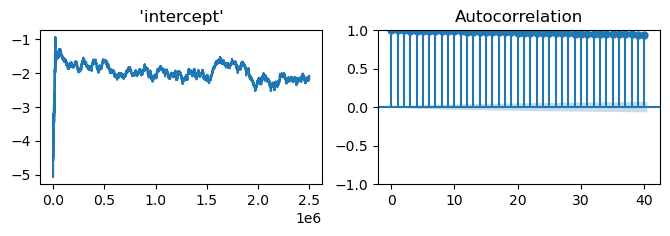

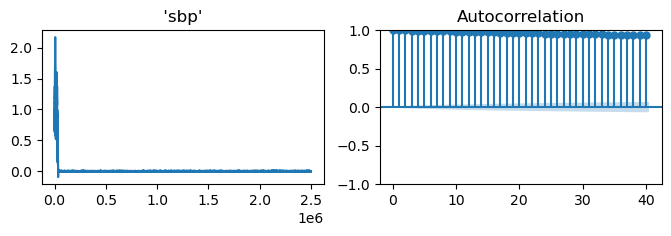

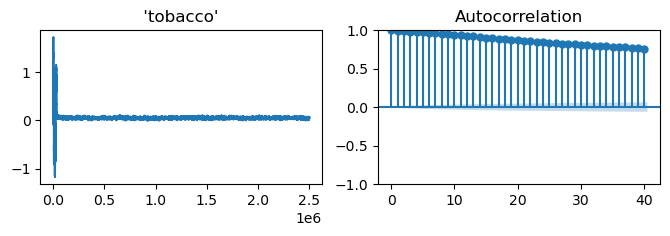

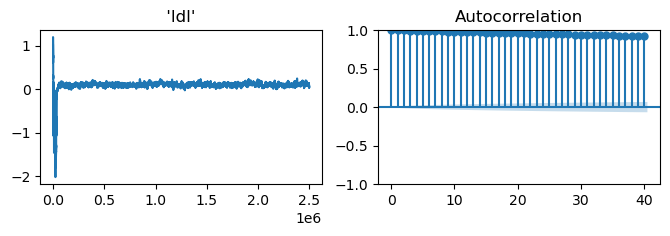

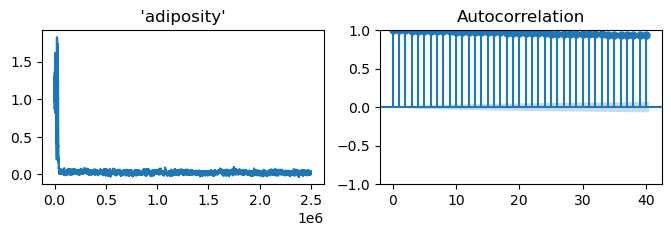

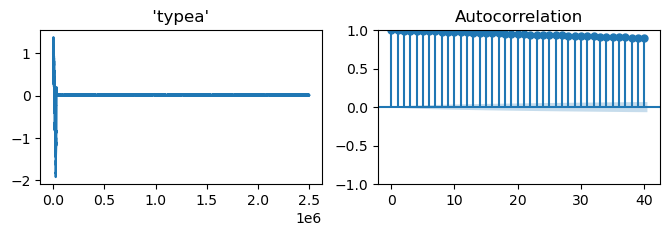

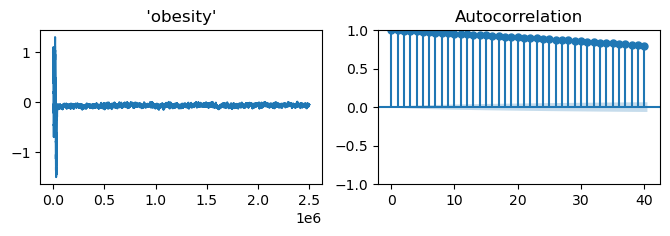

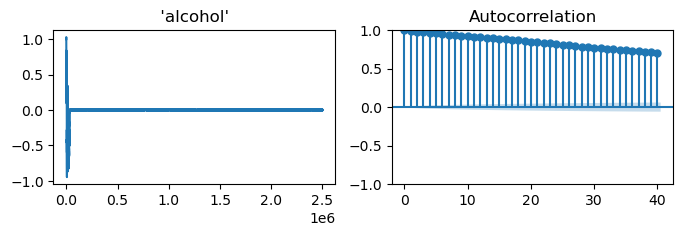

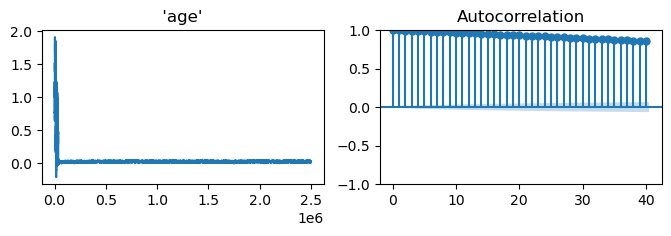

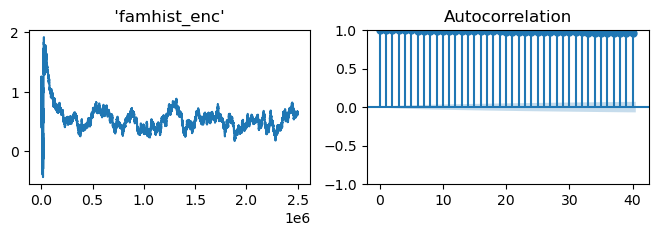

In [19]:
%matplotlib inline
for i in range(b_0.shape[0]):
    fig, axs = plt.subplots(1, 2, figsize=(8, 2))
    axs[0].plot(sample[:,i])
    axs[0].set_title(f" '{data.columns[i]}' ")
    
    sm.graphics.tsa.plot_acf(sample[::40,i], lags=40, ax = axs[ 1])
    plt.show()

Analyzing the plots, we now choose the most appropriate values of burnin and thinning to obtain the best coefficients. 

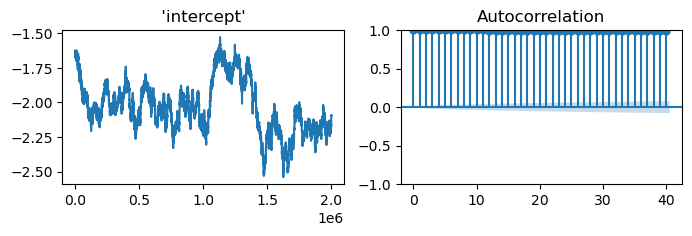

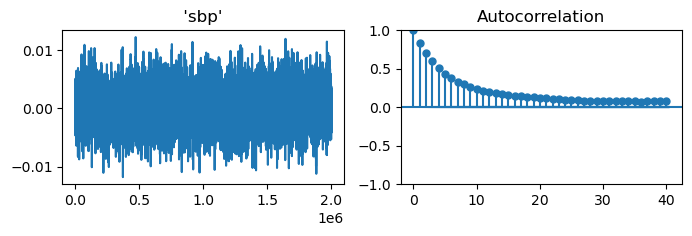

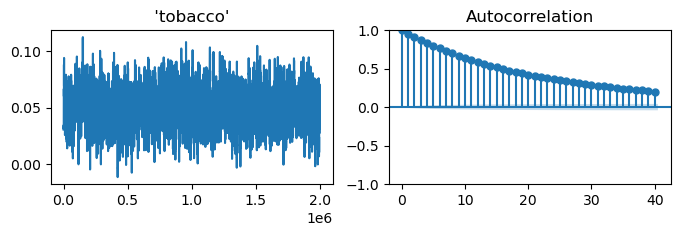

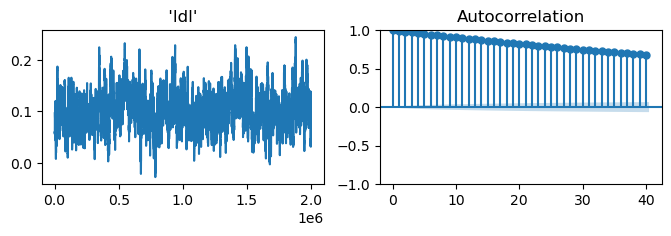

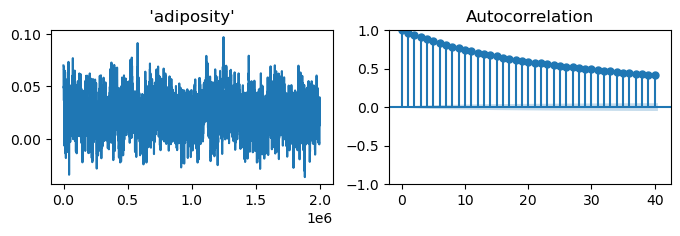

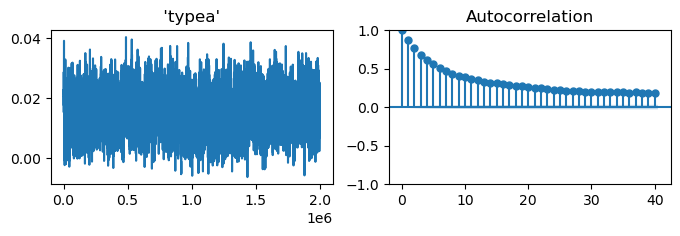

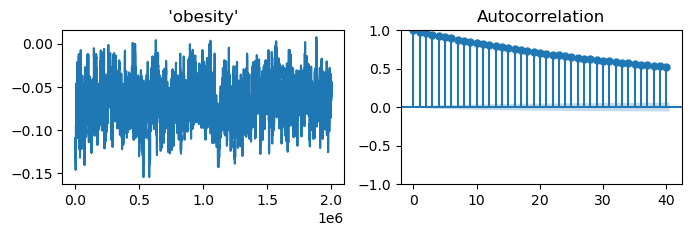

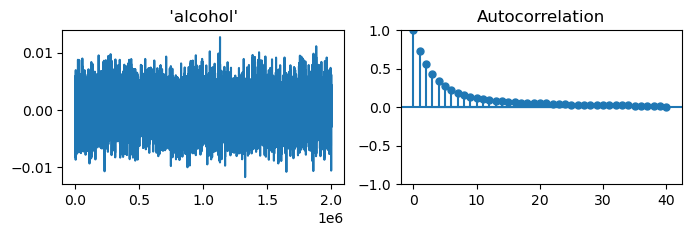

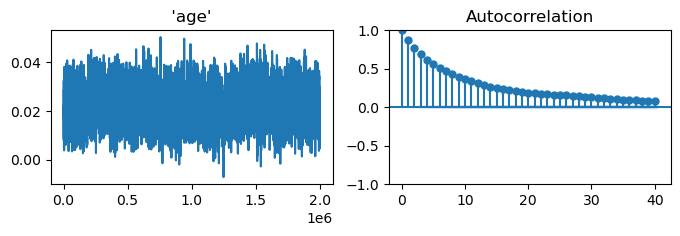

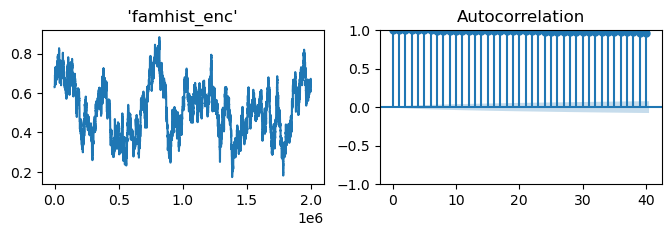

In [20]:
%matplotlib inline
for i in range(b_0.shape[0]):
    fig, axs = plt.subplots(1, 2, figsize=(8, 2))
    axs[0].plot(sample[500000:,i])
    axs[0].set_title(f" '{data.columns[i]}' ")
    
    sm.graphics.tsa.plot_acf(sample[500000::40,i], lags=40, ax = axs[ 1])
    
    plt.show()

In [21]:
betas_mcmc = np.mean(sample[500000::40], axis = 0)
print(betas_mcmc.shape)
print(betas_mcmc)

(10,)
[-2.03535953e+00  1.96269835e-04  4.94479560e-02  1.02505715e-01
  2.38714989e-02  1.56571390e-02 -6.69513906e-02 -1.37329783e-04
  2.21830757e-02  5.15274361e-01]


### Calculate accuracy and marginal effects for interpretation

In [22]:
predicted_probs_mcmc = norm.cdf(np.dot(X, betas_mcmc))

predicted_classes_mcmc = (predicted_probs_mcmc > 0.5).astype(int)

accuracy_mcmc = np.mean(predicted_classes_mcmc == Y)
print(f'Accuracy: {accuracy_mcmc:.2%}')

Accuracy: 56.99%


In [23]:
marginal_effects_mcmc = norm.pdf(X_average*betas_mcmc)*betas_mcmc

In [24]:
marginal_effects_mcmc

array([-1.02324078e-01,  7.82714837e-05,  1.94106636e-02,  3.63402367e-02,
        7.92345649e-03,  4.42083976e-03, -5.84041398e-03, -5.47865067e-05,
        5.63693051e-03,  2.00905168e-01])

### Differences beetween Fisher coefficients and MCMC coefficients

In [25]:
betas_fisher - betas_mcmc

array([-1.53459840e+00,  3.59343584e-03, -1.22927237e-03,  3.24051903e-04,
       -1.14819176e-02,  7.89552945e-03,  2.67975634e-02,  1.56063830e-04,
        4.08257879e-03,  2.37751388e-02])